In [2]:
import cv2
import numpy as np
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# folder path where test images are located
path_img_test = r"/content/drive/MyDrive/Nutrigen_AI/to_test" # folder path

# exp 1 net path:
#net_path = r"F:\STUDY\BE proj\yolov4 exp 1\exp1_weights_and_files\yolov4-custom_LastAround2500.weights"

#  net  or weight file path
net_path = r"/content/drive/MyDrive/Nutrigen_AI/custom-yolov4-detector_best(somewhere 98.62).weights"

# exp 1 cfg path:
#cfg_path = r"F:\STUDY\BE proj\yolov4 exp 1\yolov4-custom.cfg"

# cfg file path:
cfg_path = r"/content/drive/MyDrive/Nutrigen_AI/custom-yolov4-detector.cfg"

results_path = r"/content/drive/MyDrive/Nutrigen_AI/results"

cropped_img_path = r"/content/drive/MyDrive/Nutrigen_AI/cropped_img"

#obj_file = r""

# folder path to store generated result images  data
img_results = r"/content/drive/MyDrive/Nutrigen_AI/final_result_img"


In [4]:
path_img_test

'/content/drive/MyDrive/Nutrigen_AI/to_test'

In [7]:
#  object file path
# exp2_objNames = r"C:\Users\Chetan\Downloads\exp2_darknet_Yolov4_obj.names"
exp2_objNames = r"/content/drive/MyDrive/Nutrigen_AI/darknet_Yolov4_obj_names.names"

exp1_objNames = "obj.names"
classes = []
with open(exp2_objNames,"r") as f:
    classes = [line.strip() for line in f.readlines()]

i=0
for c in classes:
    print(f"{i}.-{c},",end=" ")
    i+=1


0.-Apple, 1.-Banana, 2.-Carrot, 3.-Onion, 4.-Orange, 5.-Qiwi, 6.-Tomato, 7.-thumb, 

# Load YOLO

In [8]:

net = cv2.dnn.readNet(net_path,cfg_path)

net.getLayerNames()

net.getUnconnectedOutLayers()
layer_names = net.getLayerNames()
# outputlayers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
outputlayers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]
#print(outputlayers)


colors= np.random.uniform(0,255,size=(len(classes),3))
# check the color data for bounding box colors
# print(colors)




# helper functions for showing images

In [9]:
# fun 1

def imShow(path):
    if type(path) == str():
        image = cv2.imread(path)
    else:
        image = path

    height, width = image.shape[:2]
    resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.show()

# Helper crop function

In [10]:
#def crop_img(img_save_path,bb_cordinate):
def crop_img(img_save_path, img_name ,bb_cordinate):
    dh,dw,cha = img1.shape

    # if any bb cor-number is less than zero make it positive
    for i in range(len(bb_cordinate)):
        if bb_cordinate[i] < 0:
            bb_cordinate[i] = abs(bb_cordinate[i])

    xmin,ymin, w, h = bb_cordinate # e.g [372, 33, 170, 295] # reactangle data

    p = 5 # pixel numbver to add
    # to add 5 more pixels at the left side
    x_MIN =0
    if xmin - p >= 1 :# xmin
        X_MIN = xmin - p
    else:
        X_MIN = xmin

    # to add 5 more pixels at the Above side
    if ymin -p >=1  :    # ymin
        Y_MIN =  ymin -p
    else:
        Y_MIN = ymin


    if (ymin + h) + p > dh:    # Y max
        Y_MAX = (ymin + h)
    else: # to add 5 more pixels at the bottom side
        Y_MAX = (ymin + h) + p

    if (xmin+ w) + p > dw:    # x max
        X_MAX = (xmin+ w)
    else: # to add 5 more pixels at the right side
        X_MAX = (xmin+ w) + p

    #print()       above+5    bottom+5    left+5    right+5
    #imgCrop = img1[ ymin:   ymin + h  ,  xmin:    xmin+ w  ]

    imgCrop = img1[ Y_MIN : Y_MAX  , X_MIN : X_MAX ]

    # store the every cropped img data into dictionary
    cropped_img_dict = {}
    cropped_img_dict[ img_name ] = imgCrop

    #print(imgCrop)
    #cv2.imwrite( img_save_path, imgCrop)
    cv2.imwrite( os.path.join(img_save_path,img_name) , imgCrop)

    #return cropped_img_dict , bb_cordinate
    return img_name , imgCrop , bb_cordinate



# funtion 2 for detection objects

In [11]:
# fun 2
def detecting_objects(img1):

    # start time
    start_time = time.time()
    count = 0
    #blob = cv2.dnn.blobFromImage(img1,0.00392,(416,416),(0,0,0),True,crop=False)
    blob = cv2.dnn.blobFromImage(img1,0.00392,(608,608),(0,0,0),True,crop=False)

    net.setInput(blob)
    outs = net.forward(outputlayers)


    #Showing info on screen/ get confidence score of algorithm in detecting an object in blob
    class_ids=[]
    confidences=[]
    boxes=[]
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]


            if confidence > 0.5:
                #object detected
                center_x= int(detection[0]*width)
                center_y= int(detection[1]*height)
                w = int(detection[2]*width)
                h = int(detection[3]*height)

                #cv2.circle(img,(center_x,center_y),10,(0,255,0),2)
                #rectangle co-ordinaters
                x=int(center_x - w/2)
                y=int(center_y - h/2)
                #cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

                boxes.append([x,y,w,h]) #put all rectangle areas
                confidences.append(float(confidence)) #how confidence was that object detected and show that percentage
                class_ids.append(class_id) #name of the object tha was detected
                #bounding_box_dict['class_ids_'+str(count)] = [center_x,center_y,w,h]
                count += 1
    # end time
    end_time = time.time()
    print(f"all objects Bounding Boxes,Confidences,class id's are found in : {end_time - start_time} Seconds")
    return class_ids , confidences , boxes


## segmentation funtion :

In [12]:
import matplotlib.image as mpimg

def Segmentaion(cropped_img_name,cropped_img,img_cordinates):

    # start time
    start_time = time.time()
    #original img
    #cv2_img=cv2.imread(cropped_img)
    cv2_img=cropped_img   #cropped_img[ : , : , ::-1 ]

    #gray scale img
    #cv2_img_gray=cv2.imread(cropped_img,0)
    cv2_img_gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

    adap_thresh = cv2.adaptiveThreshold(cv2_img_gray,100,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,2)

    contours,hierarchy = cv2.findContours(adap_thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    largest_areas = sorted(contours,key=cv2.contourArea)
    mask = np.zeros(cv2_img_gray.shape , np.uint8)
    img_contour = cv2.drawContours(mask,[largest_areas[-1]],0,(255,255,255,255),-1)

    # take original img again
    #plt_img = mpimg.imread(cropped_img)
    plt_img = cropped_img

    img_bitcontour = cv2.bitwise_or(plt_img,plt_img,mask=mask)
    hsv_img = cv2.cvtColor(img_bitcontour,cv2.COLOR_BGR2HSV)
    mask_plate = cv2.inRange(hsv_img,np.array([0,0,50]),np.array([200,90,250]))

    mask_not_plate = cv2.bitwise_not(mask_plate)
    # final segmented img of object
    mask_fruit = cv2.bitwise_and(img_bitcontour,img_bitcontour,mask=mask_not_plate)

    #titles = ["original",'Output',"masked of final fruit"]
    #images = [cv2_img,mask_fruit_finger,mask_not_plate]

    # process futher to get the contour of segmended img
    rgb_img = mask_fruit.copy()
    img_gray2 = cv2.cvtColor(rgb_img,cv2.COLOR_BGR2GRAY)
    adap_thresh2 = cv2.adaptiveThreshold(img_gray2,100,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,2)
    cont2 ,_ = cv2.findContours(adap_thresh2,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    largest_areas2 = sorted(cont2,key=cv2.contourArea)
    print(f"total numbers of contour is: {len(largest_areas2)} for {cropped_img_name}")
    mask2 = np.zeros(img_gray2.shape , np.uint8)
    cop = mask2.copy()
    #                0        1        2          3        4        5         6         7
    label_list = ["thumb" , "Apple", "Banana", "Orange", "Qiwi", "Tomato", "Carrot", "Onion" ]
    #            -1or-2     -1         -1         -1       -1       -1        -2      -1or-2

    Thumb_img_min_rectangle = None
    if cropped_img_name.startswith(label_list[0]): # thumb
        req_contour = largest_areas2[-1]
        img_contour4 = cv2.drawContours(cop,[req_contour],0,(255,255,255,255),-1)
        req_object_area = cv2.contourArea(req_contour)

        min_rectangle = img_contour4.copy()
        rect = cv2.minAreaRect(req_contour)
        box = cv2.boxPoints(rect)
        box2 = box.copy()
        box2 = np.int0(box)

        pix_height = max(rect[1])
        pix_to_cm_multiplier = 5.0/pix_height

        min_rectangle = img_contour4.copy()
        copy_original = cv2_img.copy()
        Thumb_img_min_rectangle = cv2.drawContours(copy_original , [box2],0 ,(0,255,0), 2)

        print(f"\nrectangle is: {rect} \nbox points are: {box} \n pixel hight: {pix_height} \npixel multiplier is : {pix_to_cm_multiplier}")

        # result = [req_object_area , pix_to_cm_multiplier ]
        result = [req_contour , req_object_area , pix_to_cm_multiplier]

    elif cropped_img_name.startswith(label_list[6]): # carrot
        req_contour = largest_areas2[-2]
        img_contour4 = cv2.drawContours(cop,[req_contour],0,(255,255,255,255),-1)
        req_object_area = cv2.contourArea(req_contour)
        # result = [req_object_area]
        result = [req_contour , req_object_area ]

    else:                                   # rest all
        req_contour = largest_areas2[-1]
        img_contour4 = cv2.drawContours(cop,[req_contour],0,(255,255,255,255),-1)
        req_object_area = cv2.contourArea(req_contour)
        # result = [req_object_area]
        result = [req_contour , req_object_area ]

    print(f"\nthe largest_fruit_contour is : {req_object_area} which is of {cropped_img_name}")
    # end time
    end_time = time.time()
    print(f"segmentation of an object is done in : {end_time - start_time} Seconds")

    # final ==> return thumb contour or fruit contour and Thumb Contour Area And Fruit Contour Area
    #     and PIXEl to CM  = returns => FC or TC + TCA or FCA + Pixel_to_cm  , image data

    img_data_list = [cv2_img, mask_fruit, img_contour,img_contour4]
    if Thumb_img_min_rectangle is not None:
        img_data_list.append(Thumb_img_min_rectangle)
    return  result , img_cordinates , img_data_list

## calories :

In [13]:
# 1.-Apple, 2.-Banana, 3.-Carrot, 4.-Onion, 5.-Orange, 6.-Qiwi, 7.-Tomato, 8.-thumb,

# "thumb""0.641
#density - gram / cm^3
density_dict = { "Apple":0.96, "Banana":0.94,  "Carrot":0.641,"Onion":0.513, "Orange":0.482,"Tomato":0.481 , "Qiwi" :0.575 }
#kcal
calorie_dict = { "Apple":52, "Banana":89,  "Carrot":41 , "Onion":40 , "Orange":47 , "Tomato":18 , "Qiwi":44 }

#skin of photo to real multiplier
skin_multiplier = 5*2.3

#                0        1        2          3        4        5         6         7
label_list = ["thumb" , "Apple", "Banana", "Orange", "Qiwi", "Tomato", "Carrot", "Onion" ]
#            -1or-2     -1         -1         -1       -1       -1        -2      -1or-2


def getCalorie(label, volume): #volume in cm^3
    calorie = calorie_dict[label]
    density = density_dict[label]
    mass = volume*density*1.0
    calorie_tot = (calorie/100.0)*mass
    return mass, calorie_tot, calorie #calorie per 100 grams

#                    fruitA   thumbA            PC                FC
def getVolume(label, area, skin_area, pix_to_cm_multiplier, fruit_contour):
    area_fruit = (area/skin_area)*skin_multiplier #area in cm^2
    # lebel = string = label_list[i]
    # #label = int(label)
    volume = 100
    #              1                        5                      7                          6
    if label == label_list[1] or label == label_list[3] or label == label_list[4] or label == label_list[5] or label == label_list[7] : #sphere-apple,orange,kiwi,tomato,onion
        radius = np.sqrt(area_fruit/np.pi)
        volume = (4/3)*np.pi*radius*radius*radius
        #print (area_fruit, radius, volume, skin_area)

    #      2             4                3
    if label == label_list[2] or label == label_list[6] and area_fruit > 30 : #cylinder like banana, cucumber, carrot
        fruit_rect = cv2.minAreaRect(fruit_contour)
        height = max(fruit_rect[1])*pix_to_cm_multiplier
        radius = area_fruit/(2.0*height)
        volume = np.pi*radius*radius*height

    if (label==4 and area_fruit < 30) : # carrot
        volume = area_fruit*0.5 #assuming width = 0.5 cm

    return volume

def calories(segmentation_to_calorie):
    # segmentation_to_calorie == dict()
    # key =  obj name + confidence+_bbNum + .jpg
    # value = [ [ thumb/fruit Contour ,/, thumb/fruit Contour-Area , pix_cm ] , img_cordinates  ]

    # 1.-Apple, 2.-Banana, 3.-Carrot, 4.-Onion, 5.-Orange, 6.-Qiwi, 7.-Tomato, 8.-thumb,

    # start time
    start_time = time.time()
    fruit_calories_dict = {}

    skin_contour_Area = pix_cm = None

    for k in segmentation_to_calorie:
        if k.startswith("thumb"):
            skin_contour = segmentation_to_calorie[k][0][0]
            skin_contour_Area = segmentation_to_calorie[k][0][1]
            pix_cm = segmentation_to_calorie[k][0][2]

            img_cordinates = segmentation_to_calorie[k][1]
            # 'Carrot(95.66)_10.jpg'
            fruit_calories_dict[k] = [ k.split("_")[0]  , img_cordinates]

    if skin_contour_Area is None and  pix_cm is None:
        print("++++++++++++|||-------------*************** IMP NOTE ***************-------------|||++++++++++++")
        print("\n********------!***!------********\nReferance Object is not present in image please provide one to move ahead for calories\n********------!***!------********\n")
        print("++++++++++++|||-------------*************** IMP NOTE ***************-------------|||++++++++++++\n")

    for k in segmentation_to_calorie:
        if not k.startswith("thumb"):
            fruit_contour = segmentation_to_calorie[k][0][0]
            fruit_contour_Area = segmentation_to_calorie[k][0][1]

            # key =  objName(confidence)_bbNum.jpg
            # key = 'Carrot(95.66)_10.jpg'
            name = k.split("_")[0].split("(")[0] # objName
            objName_Confidence =  k.split("_")[0]
            bbNum = k.split("_")[1][:-4]   # k[-6:-4]
            img_cordinates = segmentation_to_calorie[k][1]

            if skin_contour_Area is not None  and pix_cm is not None:
                volume = getVolume(name, fruit_contour_Area, skin_contour_Area, pix_cm, fruit_contour)
                mass, cal, cal_100 = getCalorie(name, volume)
                fruit_volumes=volume
                fruit_calories_100grams=cal_100
                fruit_mass=mass
                fruit_calories = cal

                #print(f"\nfruit_volumes {fruit_volumes},\nfruit_calories {fruit_calories},fruit_calories_100grams {fruit_calories_100grams}, \nfruit_mass {fruit_mass}")
                final_result_name = str(objName_Confidence) +"_"+ str(round(fruit_calories))+"kcal" +"_"+str(bbNum)
                print(final_result_name , img_cordinates )
                #fruit_calories_dict[k] = [ final_result_name , img_cordinates ]
                print(f"Calorie estimation done for--> {name} and Calorie is {round(fruit_calories,3)} kcal/g \n")
            else:
                final_result_name = str(objName_Confidence) +"_"+str(bbNum)

            fruit_calories_dict[k] = [ final_result_name , img_cordinates ]

    # end time
    end_time = time.time()
    print(f"all object Calories are found in : {end_time - start_time} Seconds")

    return fruit_calories_dict



# funtion 3 to draw detection data on images


In [14]:
# class_ids , confidences , boxes
# def fun 3
def find_required_detections(input_image , class_ids , confidences , boxes):
    global drawn
    global required_bb_detections , whole_img_name #, history_cropped_images  #, history_final_result_img
    required_bb_detections  = {}
    history_cropped_images = {}

    #history_final_result_img = []

    # start time
    start_time = time.time()

    #cv2.dnn.NMSBoxes(boxes,confidences,score_threshold,IOU_threshold)
    indexes = cv2.dnn.NMSBoxes(boxes,confidences,0.4,0.6)#Non Max Suppressions

    print(f"the required bb's indexes are: \n",indexes)

    '''Now using below loop over all found boxes,
    if box is appearing in indexes then only draw rectangle, color it,
    put text of class name on it.'''
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i  in indexes:
            x,y,w,h = boxes[i]
            label = str(classes[class_ids[i]])

            whole_img_name = f"{images_list[ask_img][:-4]}_{label}({round(confidences[i]*100 ,2)})_{i}.jpg"

            img_name = f"{label}({round(confidences[i]*100 ,2)})_{i}.jpg"
            print(f"\nthe the respective lables are--> BB_No.{i} = {label}")

            # gather the name of obj and its coordinatesonly which are required
            required_bb_detections[img_name] = boxes[i]
    # end time
    end_time = time.time()
    print(f"all required object are found in : {end_time - start_time} Seconds")

    # --------------------------*****************************--------------------------

    cropped_img_dict = {}
    segmented_img_dict = {}
    segmentation_to_calorie = {}
    fruit_calories_dict = {}
    # for every img call required function calls for processing
    print("\n***********------ images processing part 2 started ------***********\n")
    # start time
    start_time = time.time()
    for k in required_bb_detections:

        ### ******* crop img funcion call
        """
        it returns ==> cropped_img_dict
        - cropped img dict --> key= "img name" = label + confidence + requireed NBN bb number" ,
                            value = cropped img Array data --> img data
        - the bb cordinates of obj = refined bounding box(bb) cordinates
        """
        cropped_img_name ,cropped_img ,refined_obj_bb_box  = crop_img(cropped_img_path, k ,required_bb_detections[k] )
        cropped_img_dict[cropped_img_name] = cropped_img
        history_cropped_images[images_list[ask_img][:-4]] = cropped_img_dict # global
        print(f"\ncropping done for--> {cropped_img_name}")

        ### ******* Segmentation of img funcion call
        """
        returns ==> segmented_img_dict [img name] = [ original img , segmented img , contour drawn img]
        - key = name of cropped img with its confidence
        - value = segemted object img data
        """
        segmented_obj_contour_area_pixel, img_cordinates , segmented_images_data  = Segmentaion(cropped_img_name,cropped_img,required_bb_detections[k])
        segmented_img_dict[cropped_img_name] = segmented_images_data
        # if thumb then : len > 2  and list[0] = contour  of food or thumb ;list[1]=Contour Area ;list[2] = pixel to centimeter
        # image cordinates
        segmentation_to_calorie[cropped_img_name] = [segmented_obj_contour_area_pixel , img_cordinates]

        print(f"Segmentaion done for--> {cropped_img_name} and Area is {segmented_obj_contour_area_pixel[1]}")

    print("\n------------------***------------------\n")

    ## Calories funtion call --> collect all the calories of required objects
    """
        returns the calories of each segmented food object through calories function
        returns: dict --> fruit_calories_dict gives==> final_data
        - key = img name+confidence+bbNum.jpg ==> objName(confidence)_bbNum.jpg
        - value = [ img name+confidence+calories+bbNum , bounding box cordinates ]
    """
    final_data = calories(segmentation_to_calorie)
    # end time
    end_time = time.time()
    print(f"image processing part 2 completed in : {end_time - start_time} Seconds")

     # --------------------------*****************************--------------------------



    print("\n***********------ images Display part started ------***********\n")
    start_time = time.time()
    print(final_data,f"\nlength of dictionary is: {len(final_data)}")

    result_img = input_image.copy()
    print("\n copy img before detection is---:\n")
    imShow(result_img)

    for k in final_data:
        ## key = objName(confidence)Calories_bbNum.jpg
        ## value = [ img name+confidence+calories+bbNum , bounding box cordinates ]

        ## example :
        doc_string = """
          dictionary = { "thumb / fruit" : [ objectName , [bounding box]  ] ,
                         "apple"         : [ apple(89.34)_45Kcal_5 , [372, 33, 170, 295] ],
                          ....
                        }
        """

        final_img_name, BB_Cordinates = final_data[k][0] , final_data[k][1]
        font = cv2.FONT_HERSHEY_PLAIN
        x,y,w,h = BB_Cordinates

        color = colors[2] #colors[i//2]
        cv2.rectangle(result_img,(x,y),(x+w,y+h),color,2)

        cv2.putText(result_img,final_img_name,(x,y+30),font,1,(255,255,255),2)
        print(f"Drawn part done for--> {final_img_name} ")

    end_time = time.time()
    print(f"display part done in {end_time - start_time} Seconds")
    print("\n copy img After detection is---:\n")
    imShow(result_img)

    if choice >=3:
        drawn = cv2.imwrite(os.path.join(img_results, "result_Original_"+images_list[ask_img]) , result_img)
    else:
        drawn = cv2.imwrite(os.path.join(img_results, "result_"+images_list[ask_img]) , result_img)

    print("\n***********------ images Display part ended ------***********\n")




    return result_img , history_cropped_images , segmented_img_dict , segmentation_to_calorie , final_data



# collect all the data for later use - History

In [15]:
history_final_result_img = [ ]

def show_history(history_list):

    order , limit = map( int, input("""
    enter '1' for seeing in recent order else enter 0 to see from very start
    and limit for displaying the total number of images
    """).split() )

#     if limit >=1  and  limit <= len(history_list):
#         limit = limit
#     elif len(history_list) > 5 :
#         limit = 5
#     elif limit > len(history_list):
#         print(f" limit value exceeded the length of array plz provide value less than {len(history_list)}")
#         limit = input("enter the limit value again : ")
# #     limit = 1 # default 1 if limit exx
#     if order ==1:
#         limit = len(history_list) - limit
#         for i in range(len(history_list)-1, limit, -1):
#             imShow(history_list[i])
#     elif order == 0:
#         for i in range(limit):
#             imShow(history_list[i])

    if order ==1:
        for i in range(len(history_list)-1, -1, -1):
            imShow(history_list[i])
    elif order == 0:
        for i in range(len(history_list)):
            imShow(history_list[i])



# main funtion starts here !

hi
0  -  Appls2_verti.jpg
1  -  carrots2 and apple.jpg
2  -  carrots6 and apple.jpg
3  -  carrots4.jpg
4  -  onion3.jpg
5  -  Appls21.jpg
6  -  carrots3_hori.jpg
7  -  many_apple1.jpg
8  -  onion2.jpg
9  -  carrots5 and apple.jpg
10  -  Appls1_verti.jpg
11  -  carrots3_verti.jpg
12  -  onion4.jpg
13  -  Appls4.jpg
14  -  carrots1_verti.jpg
15  -  Appls3.jpg
16  -  carrots1_hori.jpg
17  -  onion1.jpg
18  -  Appls11.jpg
19  -  carrots7.jpg
enter the no. of image u want to test : 0 to 18--> 4

enter the numeric choice(1,2,3) for scalling 
custom  : 608 x 608
custom2 : fx=0.4 , fy=0.3
custom3 : original
1
608 608 3
all objects Bounding Boxes,Confidences,class id's are found in : 6.019409894943237 Seconds
--------------------------------------------------------
No.:0-> 3 : Onion -> 67.5%
No.:1-> 3 : Onion -> 74.82%
No.:2-> 3 : Onion -> 94.88%
No.:3-> 3 : Onion -> 96.1%
No.:4-> 3 : Onion -> 97.63%
No.:5-> 3 : Onion -> 98.7%
No.:6-> 3 : Onion -> 50.48%
No.:7-> 3 : Onion -> 84.67%
No.:8-> 3 : 

<ipython-input-12-97473554c7ef>:60: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box2 = np.int0(box)


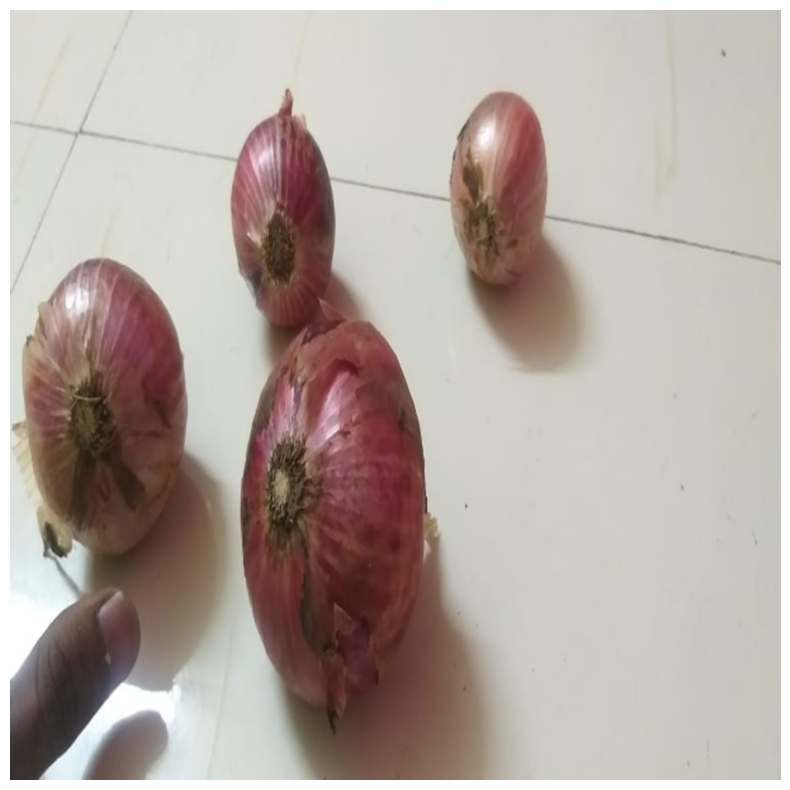

Drawn part done for--> thumb(99.52) 
Drawn part done for--> Onion(98.7)_3kcal_5 
Drawn part done for--> Onion(98.06)_1kcal_20 
Drawn part done for--> Onion(99.39)_6kcal_24 
Drawn part done for--> Onion(98.58)_13kcal_32 
display part done in 0.8088140487670898 Seconds

 copy img After detection is---:



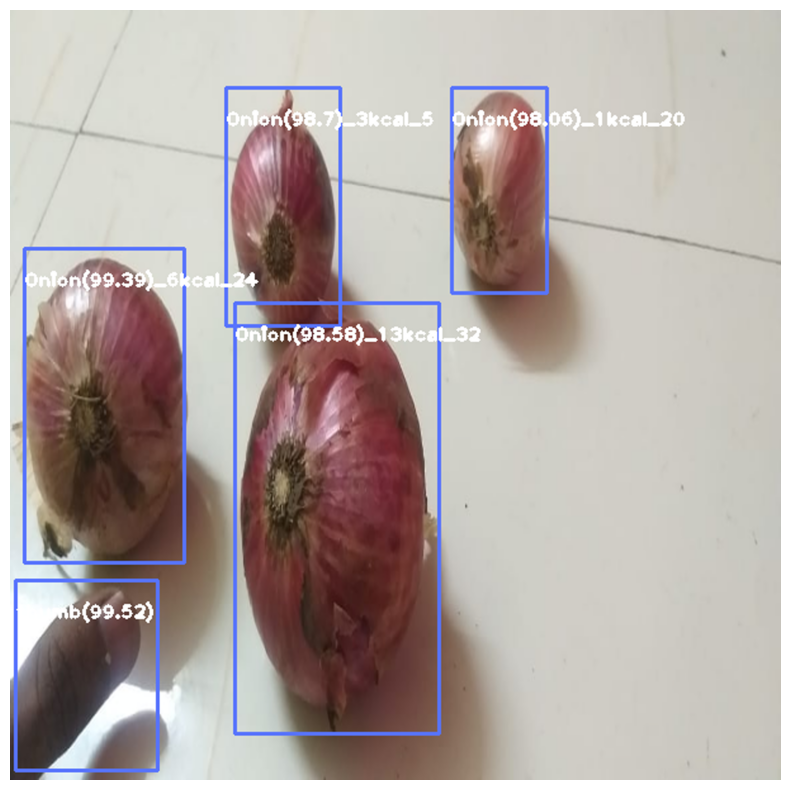


***********------ images Display part ended ------***********



Would you like to check the privious History of Images, provided you have used the system  more than once...(¬‿¬)
 ==> yes or Y / no or N 
Y

****** currently we have 1 images in our database....******

    enter '1' for seeing in recent order else enter 0 to see from very start 
    and limit for displaying the total number of images
    1


ValueError: not enough values to unpack (expected 2, got 1)

In [16]:
### loading image
print("hi")


images_list = []
for count, filename in enumerate(os.listdir(path_img_test)):
    images_list.append(filename)
    print(count," - ",images_list[count])


# ********************************************************************

ask_img = int(input(f"enter the no. of image u want to test : 0 to {count-1}--> "))
final_img = images_list[ask_img]
#final_img=input("enter the img : ")


img1 = cv2.imread(r"{}".format(os.path.join( path_img_test ,final_img)))
#img = cv2.imread("C:\Users\Chetan\Desktop\app.jpg")

choice =  int(input("""
enter the numeric choice(1,2,3) for scalling
custom  : 608 x 608
custom2 : fx=0.4 , fy=0.3
custom3 : original
"""))

if choice ==1:
    img1 = cv2.resize(img1,(608,608))
elif choice ==2:
    img1 = cv2.resize(img1,None,fx=0.4,fy=0.3)
else:
    img1= img1

height,width,channels = img1.shape
print(height,width,channels)
#--------------------------------------------------------------
class_ids , confidences , boxes  =  detecting_objects(img1) # fun 2
print("--------------------------------------------------------")

if class_ids == []:
    print(" clould not be able to detect object inside image..!!")

else:
    for i in range(len(class_ids)):
        print(f"No.:{i}-> {class_ids[i]} : {classes[class_ids[i]]} -> {round(confidences[i]*100 ,2)}%")

print("--------------------------------------------------------")
#c1+=1

# fun 3
result_img , history_cropped_images , segmented_img_dict , segmentation_to_calorie , final_data = find_required_detections(img1 , class_ids , confidences , boxes)


# print("\nthe result image is ")
# imShow(result_img)

history = input("\n\nWould you like to check the privious History of Images, provided you have used the system  more than once...(¬‿¬)\n ==> yes or Y / no or N \n")
history_final_result_img.append(result_img)
if history == "yes"  or history == "Y":
    print(f"\n****** currently we have {len(history_final_result_img)} images in our database....******")
    #print(history_final_result_img)
    show_history(history_final_result_img)


In [ ]:
###